
# Gromov-Wasserstein Distance Between Object Feature Groups

This notebook demonstrates how to compute pairwise Gromov-Wasserstein (GW) distances between a collection of objects, each represented by a set of feature vectors (samples). 



In [12]:
import pandas as pd
import numpy as np
import ot
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.cluster.hierarchy import linkage, fcluster


## Defining Functions

In [ ]:
def compute_distance_matrix(features):
    n = features.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i, j] = np.linalg.norm(features[i] - features[j])
    return D


In [3]:

def compute_gw_distance(C1, C2, p, q):
    gw_dist, log = ot.gromov.gromov_wasserstein2(C1, C2, p, q, 'square_loss', log=True)
    return gw_dist


In [4]:

def compute_all_gw_distances(object_feature_list):
    n_objects = len(object_feature_list)
    gw_matrix = np.zeros((n_objects, n_objects))
    for i in range(n_objects):
        for j in range(n_objects):
            C1 = compute_distance_matrix(object_feature_list[i])
            C2 = compute_distance_matrix(object_feature_list[j])
            p = np.ones((C1.shape[0],)) / C1.shape[0]
            q = np.ones((C2.shape[0],)) / C2.shape[0]
            gw_matrix[i, j] = compute_gw_distance(C1, C2, p, q)
    return gw_matrix


In [14]:
def find_optimal_merge_plan(similarity_matrix, final_clusters):
    similarity_matrix = similarity_matrix.to_numpy() if isinstance(similarity_matrix, pd.DataFrame) else similarity_matrix
    n = similarity_matrix.shape[0]
    
    # Convert similarity matrix to distance matrix
    distance_matrix = 1 - similarity_matrix
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix[np.triu_indices(n, 1)], method='average')
    cluster_labels = fcluster(linkage_matrix, t=linkage_matrix[-final_clusters, 2], criterion='distance')
    
    # Group items based on cluster labels
    clusters = {}
    for idx, label in enumerate(cluster_labels, start=0):
        if label not in clusters:
            clusters[label] = set()
        clusters[label].add(idx)
    
    # Ensure exactly final_clusters groups
    while len(clusters) > final_clusters:
        smallest_cluster = min(clusters, key=lambda k: len(clusters[k]))
        nearest_cluster = min((c for c in clusters if c != smallest_cluster),
                              key=lambda c: min(distance_matrix[i-1, j-1] for i in clusters[smallest_cluster] for j in clusters[c]))
        
        clusters[nearest_cluster] |= clusters[smallest_cluster]
        del clusters[smallest_cluster]
    
    return list(clusters.values())

## Example

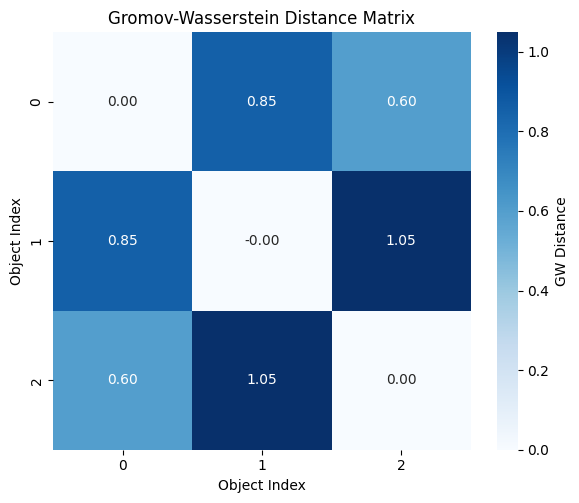

In [5]:

# Define three objects, each with samples represented by 2D feature vectors
np.random.seed(0)
object_1 = np.random.normal(loc=0.0, scale=1.0, size=(5, 2))
object_2 = np.random.normal(loc=5.0, scale=1.0, size=(6, 2))
object_3 = np.random.normal(loc=2.5, scale=1.0, size=(4, 2))

# Group the objects
objects = [object_1, object_2, object_3]

# Compute GW distances
gw_distances = compute_all_gw_distances(objects)

# Visualize
plt.figure(figsize=(6, 5))
sns.heatmap(gw_distances, annot=True, fmt=".2f", cmap="Blues", square=True, cbar_kws={'label': 'GW Distance'})
plt.title("Gromov-Wasserstein Distance Matrix")
plt.xlabel("Object Index")
plt.ylabel("Object Index")
plt.tight_layout()
plt.show()


We convert the distance matrix to a similary matrix.

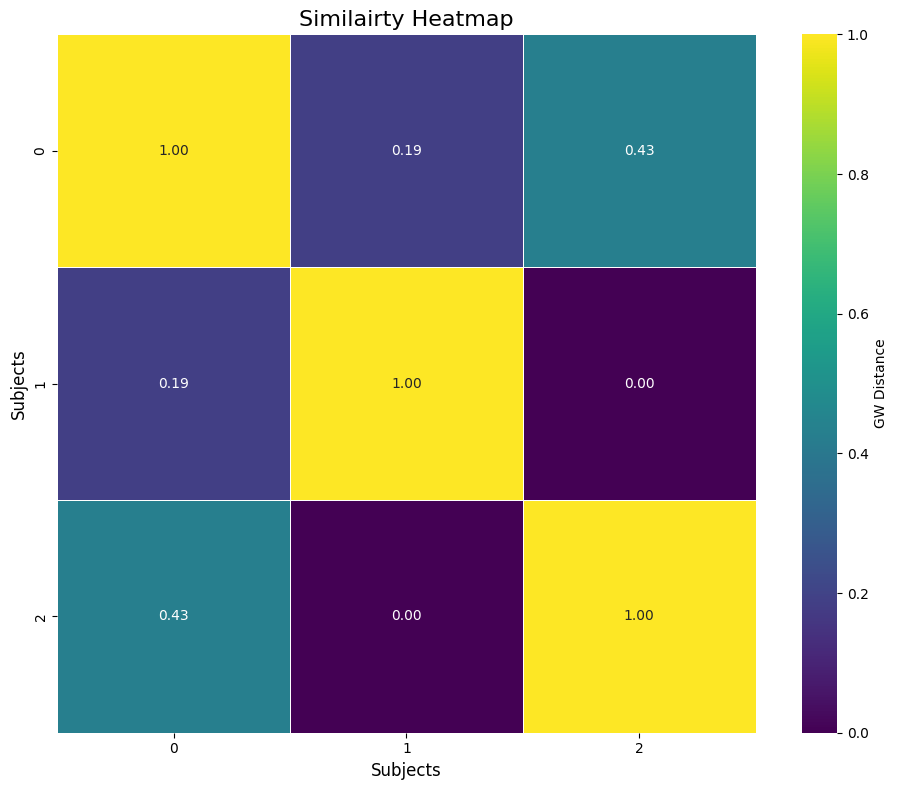

In [ ]:
min_value = gw_distances.min()
max_value = gw_distances.max()

gw_scaled = (gw_distances - min_value) / (max_value - min_value)

# Compute 1 - scaled values
gw_transformed = 1 - gw_scaled




plt.figure(figsize=(6, 5))
sns.heatmap(
    gw_transformed, 
    annot=True,  # Show the values in the heatmap
    fmt=".2f",  # Format values to 2 decimal places
    cmap="viridis",  # Colormap for the heatmap
    linewidths=0.5,  # Add gridlines
    square=True,  # Keep the heatmap square
    cbar_kws={'label': 'GW Distance'}  # Label for the colorbar
)

# Add titles and labels
plt.title("Similairty Heatmap", fontsize=16)
plt.xlabel("Subjects", fontsize=12)
plt.ylabel("Subjects", fontsize=12)

# Display the heatmap
plt.tight_layout()
plt.show()

In [15]:
final_clusters = 2

merge_plan = find_optimal_merge_plan(gw_transformed, final_clusters)
merge_plan

[{0, 2}, {1}]

Deciding the merge plan: model 0 and 2 should be merged